In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score


In [2]:
# Load data
df = pd.read_csv("ecommerce_dataset.csv")
df.rename(columns={"Order_Date": "Date", "Quantity": "Orders"},
inplace=True)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Feature Engineering
df['DayName'] = df['Date'].dt.day_name()
df['IsWeekend'] = df['Date'].dt.dayofweek >= 5
df['Month'] = df['Date'].dt.month
df['WeekOfYear'] = df['Date'].dt.isocalendar().week

# Encode
df_encoded = df.copy()
categorical_cols = ['Product_Category', 'Payment_Type', 'Order_Status',
'Marketing_Campaign_Status',
'Seasonality', 'DayName', 'Month', 'WeekOfYear']
df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols,
drop_first=True)

# Label encode high-cardinality
label_encoders = {}
for col in ['Product_ID', 'Customer_ID','Order_ID']:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

df_encoded['PlottingDate'] = df['Date']
df_encoded.drop(['Date'], axis=1, inplace=True)

# Restore original Product_ID for matching purposes
df_encoded['Original_Product_ID'] = label_encoders['Product_ID'].inverse_transform(df_encoded['Product_ID']
)


In [3]:
# Scaling
scaler = MinMaxScaler()
scaled_cols = ['Unit_Price', 'Total_Price', 'Discount', 'Clicks',
'Add_to_Cart']
df_encoded[scaled_cols] = scaler.fit_transform(df_encoded[scaled_cols])
# Time Series Features
for lag in [1, 7]:
    df_encoded[f'Orders_lag_{lag}'] = df_encoded.groupby('Product_ID')['Orders'].shift(lag)
for window in [3, 7]:
    df_encoded[f'Orders_MA_{window}'] = df_encoded.groupby('Product_ID')['Orders'].rolling(window).mean().reset_index(0, drop=True)
df_encoded.fillna(0, inplace=True)
df_encoded.reset_index(drop=True, inplace=True)


In [4]:
# Modeling
X = df_encoded.drop(['Orders', 'PlottingDate', 'Order_ID',
'Original_Product_ID'], axis=1)
y = df_encoded['Orders']
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.2, random_state=42)

lr = LinearRegression().fit(X_train, y_train)
rf = RandomForestRegressor(n_estimators=50, n_jobs=-1,
random_state=42).fit(X_train, y_train)
xgb = XGBRegressor(n_estimators=50, n_jobs=-1,
random_state=42).fit(X_train, y_train)

sample_products = df_encoded.loc[y_test.index,'Product_ID'].unique()[:10]
plt.figure(figsize=(14, 7))

for pid in sample_products:
    mask = (df_encoded.loc[y_test.index, 'Product_ID'] == pid)
    dates = df_encoded.loc[y_test.index][mask]['PlottingDate']
    actuals = y_test[mask].values
    preds = xgb.predict(X_test[mask])
    all_dates=[]
    all_dates.extend(dates)
    print(f"\n Predictions for Product ID: {pid}")
    for d, a, p in zip(dates, actuals, preds):
        print(f"Date: {d.strftime('%d-%m-%Y')} | Actual: {int(a)} | Predicted: {round(p)}")



 Predictions for Product ID: 18673
Date: 29-04-2023 | Actual: 4 | Predicted: 4

 Predictions for Product ID: 6701
Date: 26-05-2023 | Actual: 3 | Predicted: 3

 Predictions for Product ID: 6102
Date: 19-01-2023 | Actual: 2 | Predicted: 2

 Predictions for Product ID: 7530
Date: 29-12-2024 | Actual: 2 | Predicted: 2

 Predictions for Product ID: 11320
Date: 21-08-2024 | Actual: 1 | Predicted: 1

 Predictions for Product ID: 9956
Date: 16-01-2023 | Actual: 4 | Predicted: 4

 Predictions for Product ID: 12191
Date: 09-05-2024 | Actual: 3 | Predicted: 3

 Predictions for Product ID: 8982
Date: 23-06-2023 | Actual: 1 | Predicted: 1

 Predictions for Product ID: 6935
Date: 16-12-2023 | Actual: 3 | Predicted: 3

 Predictions for Product ID: 11090
Date: 22-03-2024 | Actual: 5 | Predicted: 5


<Figure size 1400x700 with 0 Axes>

In [5]:
# Evaluation
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Performance:")
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("R²:", r2_score(y_true, y_pred))
    evaluate_model("Linear Regression", y_test, lr.predict(X_test))
    evaluate_model("Random Forest", y_test, rf.predict(X_test))
    evaluate_model("XGBoost", y_test, xgb.predict(X_test))


In [6]:
# Forecasting
def nextday_orders(product_ids_input, df_full, model, encoded_cols,label_encoders, X_columns):
    forecast = []
    valid_ids = []
    for pid in product_ids_input:
        if pid in df_full['Original_Product_ID'].values:
            valid_ids.append(pid)
        else:
            print(f"Product ID '{pid}' not found in the data.Skipping.")
    if not valid_ids:
        return pd.DataFrame()
    for original_pid in valid_ids:
        data = df_full[df_full['Original_Product_ID'] ==
        original_pid].sort_values('PlottingDate').copy()
        if len(data) < 1:
            continue
        latest = data.iloc[-1]
        orders_lag_1 = latest['Orders']
        orders_lag_7 = data.iloc[-7]['Orders'] if len(data) >= 7 else orders_lag_1
        orders_ma_3 = data['Orders'].tail(3).mean()
        orders_ma_7 = data['Orders'].tail(7).mean() if len(data) >= 7 else orders_ma_3
        next_day = latest['PlottingDate'] + timedelta(days=1)
        row = {
        'Orders_lag_1': orders_lag_1,
        'Orders_lag_7': orders_lag_7,
        'Orders_MA_3': orders_ma_3,
        'Orders_MA_7': orders_ma_7,
        'DayName': next_day.day_name()
        }
        for col in encoded_cols:
            row[col] = 0
        day_col = f"DayName_{row['DayName']}"
        if day_col in encoded_cols:
            row[day_col] = 1
        row.pop('DayName')
        
        for col in X_columns:
            if col not in row:
                row[col] = latest.get(col, 0)
        
        row_df = pd.DataFrame([row])
        row_df = row_df.reindex(columns=X_columns, fill_value=0)
        pred = model.predict(row_df)[0]
        
        forecast.append({
        'Product_ID': original_pid,
        'Date': next_day,
        'Predicted_Orders': max(0, round(pred))
        })
    return pd.DataFrame(forecast)




In [7]:
def next7days_orders(product_ids_input, df_full, model, encoded_cols,
    label_encoders, X_columns):
    forecast = []
    valid_ids = []
    for pid in product_ids_input:
        if pid in df_full['Original_Product_ID'].values:
            valid_ids.append(pid)
        else:
            print(f"Product ID '{pid}' not found in the data. Skipping.")
    if not valid_ids:
        return pd.DataFrame()
    for original_pid in valid_ids:
        data = df_full[df_full['Original_Product_ID'] ==
        original_pid].sort_values('PlottingDate').copy()
        if len(data) < 1:
            continue
        last_orders = data['Orders'].values
        orders_lag_7 = last_orders[0] if len(last_orders) < 7 else last_orders[-7]
        orders_ma_3 = last_orders[-3:].mean() if len(last_orders) >= 3 else last_orders.mean()
        orders_ma_7 = last_orders[-7:].mean() if len(last_orders) >= 7 else last_orders.mean()
        feature_rows = []
        forecast_dates = []
        new_rows = []
        for _ in range(7):
            latest = data.iloc[-1]
            forecast_date = latest['PlottingDate'] + timedelta(days=1)
            day_name = forecast_date.day_name()
            row = {
            'Orders_lag_1': latest['Orders'],
            'Orders_lag_7': orders_lag_7,
            'Orders_MA_3': orders_ma_3,
            'Orders_MA_7': orders_ma_7,
            }
            for col in encoded_cols:
                row[col] = 0
            day_col = f"DayName_{day_name}"
            if day_col in encoded_cols:
                row[day_col] = 1
            for col in X_columns:
                if col not in row:
                    row[col] = latest.get(col, 0)

            feature_rows.append(row)
            forecast_dates.append(forecast_date)

            new_row = latest.copy()
            new_row['Orders'] = 0
            new_row['PlottingDate'] = forecast_date
            data = pd.concat([data, new_row.to_frame().T],ignore_index=True)
            features_df = pd.DataFrame(feature_rows).reindex(columns=X_columns, fill_value=0)
            preds = model.predict(features_df)
            preds = [max(0, round(p)) for p in preds]
            for date, pred in zip(forecast_dates, preds):
                forecast.append({
                'Product_ID': original_pid,
                'Date': date,
                'Predicted_Orders': pred
                })
    return pd.DataFrame(forecast)



In [8]:
def plot_nextday_forecast(forecast_df):
    if forecast_df.empty:
        print("No forecast data to plot.")
        return
    plt.figure(figsize=(10, 5))
    bars = plt.bar(forecast_df['Product_ID'],
    forecast_df['Predicted_Orders'], color='skyblue')
    plt.title("Next-Day Predicted Orders for Selected Products")
    plt.xlabel("Product ID")
    plt.ylabel("Predicted Orders")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # Annotate bars with values
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() /2, height),xytext=(0, 3), textcoords="offset points",ha='center', va='bottom', fontsize=9)
        plt.tight_layout()
        plt.show()


In [9]:

def plot_next7days_forecast(forecast_df):
    if forecast_df.empty:
        print("No forecast data to plot.")
        return
    plt.figure(figsize=(12, 6))
    for pid in forecast_df7['Product_ID'].unique():
        product_data = forecast_df[forecast_df['Product_ID'] == pid]
        plt.plot(product_data['Date'],
        product_data['Predicted_Orders'], marker='o', label=pid)
    plt.title("7-Day Forecast for Selected Products")
    plt.xlabel("Date")
    plt.ylabel("Predicted Orders")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Product ID")
    plt.tight_layout()
    plt.show()




                             Product_ID       Date  Predicted_Orders
0  4a28f42b-a705-47c7-966f-15df854f818d 2025-06-01                 2
                              Product_ID       Date  Predicted_Orders
0   4a28f42b-a705-47c7-966f-15df854f818d 2025-06-01                 2
1   4a28f42b-a705-47c7-966f-15df854f818d 2025-06-01                 2
2   4a28f42b-a705-47c7-966f-15df854f818d 2025-06-02                 2
3   4a28f42b-a705-47c7-966f-15df854f818d 2025-06-01                 2
4   4a28f42b-a705-47c7-966f-15df854f818d 2025-06-02                 2
5   4a28f42b-a705-47c7-966f-15df854f818d 2025-06-03                 2
6   4a28f42b-a705-47c7-966f-15df854f818d 2025-06-01                 2
7   4a28f42b-a705-47c7-966f-15df854f818d 2025-06-02                 2
8   4a28f42b-a705-47c7-966f-15df854f818d 2025-06-03                 2
9   4a28f42b-a705-47c7-966f-15df854f818d 2025-06-04                 2
10  4a28f42b-a705-47c7-966f-15df854f818d 2025-06-01                 2
11  4a28f42b-a705-47c7

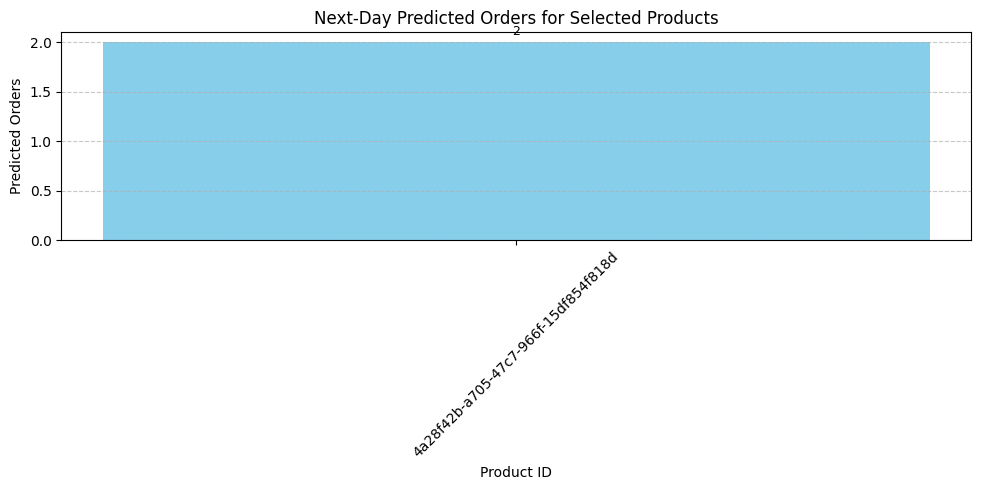

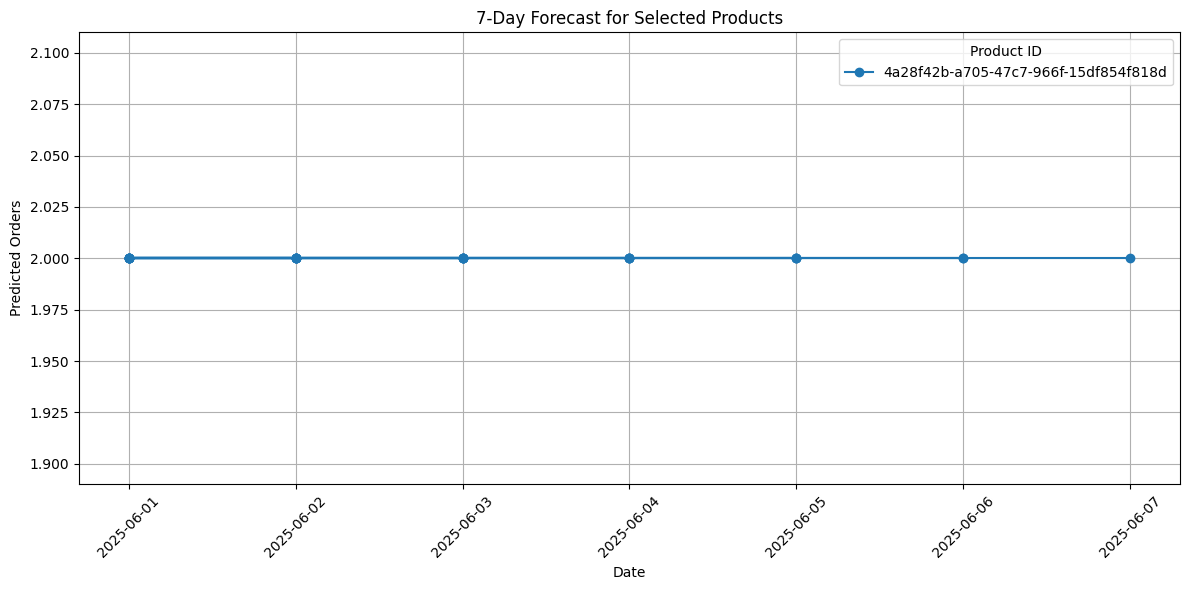

In [10]:
# Forecasting
encoded_cols = [col for col in X_train.columns if
col.startswith('DayName_')]
pids = input("Enter Product IDs (comma-separated):").strip().split(',')
pids= [pid.strip() for pid in pids if pid.strip() != ""]
forecast_df = nextday_orders(pids, df_encoded, xgb, encoded_cols,
label_encoders, X_train.columns)
print(forecast_df.head())
pids7 = input("Enter Product IDs (comma-separated):").strip().split(',')
pids7 = [pid.strip() for pid in pids7 if pid.strip()]
forecast_df7 = next7days_orders(pids7, df_encoded, xgb, encoded_cols,
label_encoders, X_train.columns)
print(forecast_df7)
plot_nextday_forecast(forecast_df)
plot_next7days_forecast(forecast_df7)


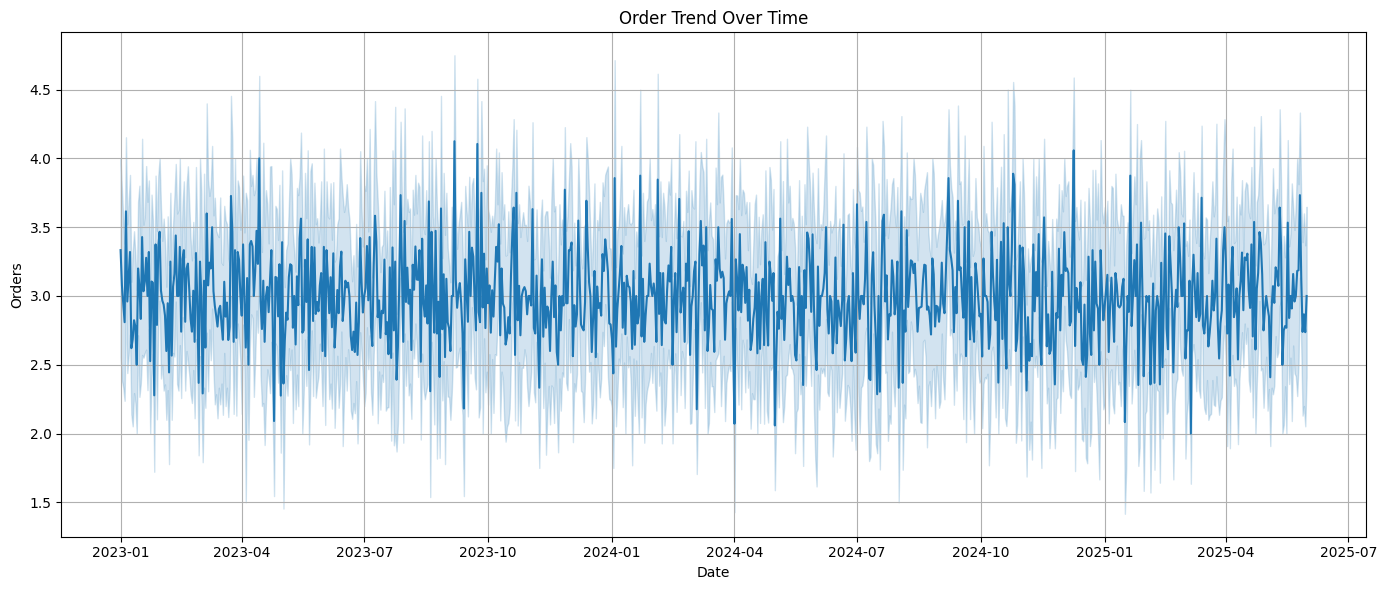

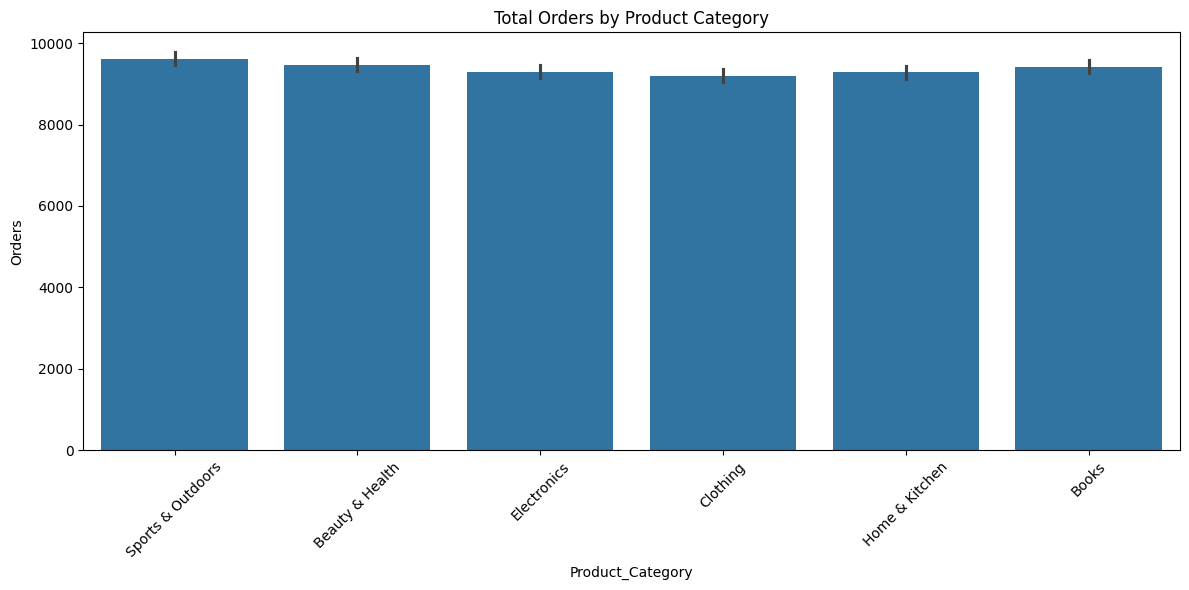

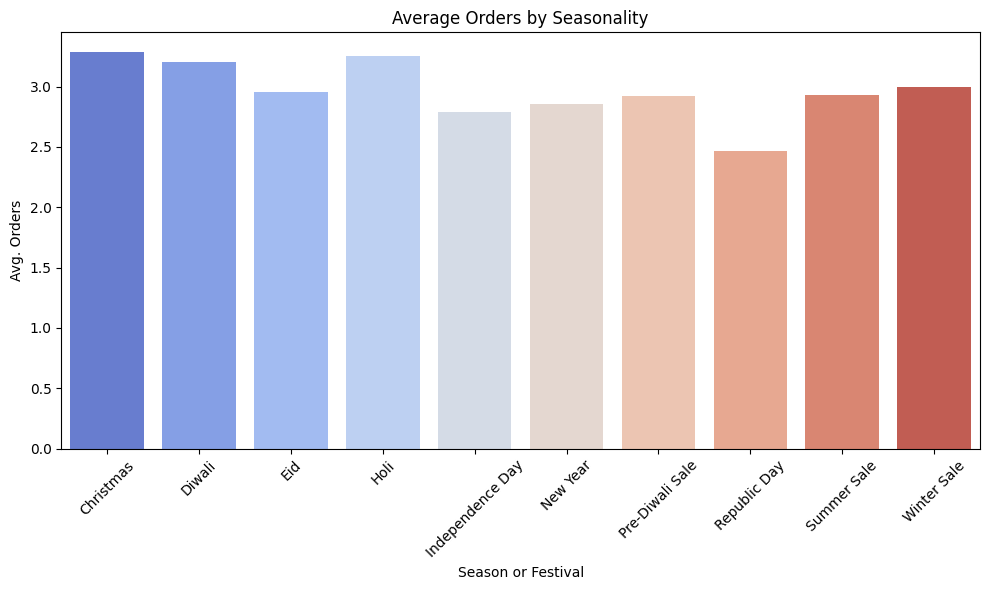

In [12]:
# Visualizations
# Order Trend Over Time
plt.figure(figsize=(14, 6))
sns.lineplot(data=df.sort_values("Date"), x='Date', y='Orders')
plt.title("Order Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Orders")
plt.grid(True)
plt.tight_layout()
plt.show()
#Total Orders by Product Category
plt.figure(figsize=(12, 6))
sns.barplot(x='Product_Category', y='Orders', data=df, estimator=sum)
plt.title("Total Orders by Product Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
#Average Orders by Seasonality
plt.figure(figsize=(10, 6))
seasonal_avg = df.groupby('Seasonality')['Orders'].mean().reset_index()
sns.barplot(data=seasonal_avg,x='Seasonality',y='Orders',hue='Seasonality',palette='coolwarm',legend=False)
plt.xticks(rotation=45)
plt.title("Average Orders by Seasonality")
plt.xlabel("Season or Festival")
plt.ylabel("Avg. Orders")
plt.tight_layout()
plt.show()

